In [46]:
import trimesh
import numpy as np
import sympy as sy
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from SkeletonOfBeam import SkeletonOfBeam
from SkeletonOfBeam import GeometryToolBox

In [2]:
mesh = trimesh.load_mesh("cantilever.stl")

In [118]:
class nBeams:
    mSob = None
    mesh = None 
    n = None
    
    aYs = []
    aZs = []
    
    nSobs = []
    
    us_xyPlane = []
    us_xzPlane = []
    dudxs_xyPlane = []
    dudxs_xyPlane = []
    
    def __init__(self, motherSob, n):
        self.mSob = motherSob
        self.mesh = motherSob.mesh.copy()
        self.n = n
        
    def getSobs(self):
        xVec, yVec, zVec = self.mSob.XYZCoordinate
        for i in range(self.n):
            print("Getting {}th sub-beam's Info...".format(i))
            sY = self.dudxs_xyPlane[i].evalf(subs={'xi': 0}) # scalar y
            sZ = self.dudxs_xzPlane[i].evalf(subs={'xi': 0}) # scalar z
            nVec = xVec + sY*yVec + sZ*zVec

            xis = np.linspace(1/self.n * i, 1/self.n * (i+1), 10)
            L = self.mSob.L
            sp = []
            for j in range(len(xis)):
                xi_value = xis[j]
                sX = xi_value * L
                sY = self.us_xyPlane[i].evalf(subs={'xi': xi_value})
                sZ = self.us_xzPlane[i].evalf(subs={'xi': xi_value})
                sp.append((sX*xVec + sY*yVec + sZ*zVec).astype('float'))
            
            sob = SkeletonOfBeam(self.mesh, np.array(nVec).astype('float'))
            sob.SkeletonPoints = sp
            
            print("Constructing {}th sub-beam...".format(i))
            sob.getNewCoordinate()
            sob.getProjections()
            sob.getSkeletonEqs()
            sob.getDerivativeSkeletonEqs()

            sob.getNewSkeletonPoints()
            sob.getNewIntersections()
            print("Done.")
            self.nSobs.append(sob)
                        
    def getNewA(self):
        n = self.n
        m = n*2 + 1
        sob = self.mSob

        L = self.mSob.L
        u_xy = self.mSob.u_xyPlane
        u_xz = self.mSob.u_xzPlane

        # Get global xi
        if m > 2:
            dis = 1/(m-1)
            xis_global = [(i+1)*dis for i in range(m-2)]
        xis_global = [0] + xis_global + [1]

        # Get local xi
        # and indexes for separations
        xis_local = (np.array(xis_global) % (1/n)) / (1/n)
        xis_local[-1] = 1
        separateIndex = [0]
        for i in range(len(xis_local)):
            if i == 0: pass
            else:
                if xis_local[i] <= xis_local[i-1]:
                    separateIndex.append(i)
        separateIndex.append(-1)

        # Get u in y and z
        uYs = []
        uZs = []
        for xi_value in range(len(xis_global)):
            uY = u_xy.evalf(subs={'xi': xi_value})
            uZ = u_xz.evalf(subs={'xi': xi_value})
            uYs.append(uY)
            uZs.append(uZ)

        # Get N
        N = np.zeros((m, 2*(n+1)))
        segL = L/n
        for i in range(len(separateIndex)-1):        
            xis = xis_local[separateIndex[i]:separateIndex[i+1]]
            if separateIndex[i+1] == -1:
                xis = np.append(xis, xis_local[-1])

            if i == n-1:
                N[separateIndex[i]:, i*2:] = SkeletonOfBeam.H(xis, segL)
            else:
                N[separateIndex[i]:separateIndex[i+1], i*2:i*2+4] = SkeletonOfBeam.H(xis, segL)

        self.aYs = np.dot(np.linalg.pinv(N), uYs).astype('float')
        self.aZs = np.dot(np.linalg.pinv(N), uZs).astype('float')
        
    def getNewEqs(self):
        self.us_xyPlane = []
        self.us_xzPlane = []
        xi = sy.symbols('xi')
        for i in range(self.n):
            if i == self.n - 1:
                aY = self.aYs[i*2:]
                aZ = self.aZs[i*2:]
            else:
                aY = self.aYs[i*2:i*2+4]
                aZ = self.aZs[i*2:i*2+4]
            self.us_xyPlane.append((SkeletonOfBeam.H(xi, L, ifsymbol=True) * aY).sum())
            self.us_xzPlane.append((SkeletonOfBeam.H(xi, L, ifsymbol=True) * aZ).sum())
            
    def getNewDerivativeEqs(self):
        xi = sy.symbols('xi')
        segL = self.mSob.L / self.n
        self.dudxs_xyPlane = [sy.diff(u, xi) / segL for u in self.us_xyPlane]
        self.dudxs_xzPlane = [sy.diff(u, xi) / segL for u in self.us_xzPlane]
            
            

## 1. Create

In [91]:
sob = SkeletonOfBeam(mesh, [1, 0, 0])
sob.getScaleAlongSkeletonVec()
sob.getIntersectionsFromStep(step=1)
sob.getSkeletonPoints()
sob.getNewCoordinate()
sob.getProjections()
sob.getSkeletonEqs()
sob.getDerivativeSkeletonEqs()
sob.getNewSkeletonPoints()
sob.getNewIntersections()

In [92]:
n = 2
interval = 1/n
m = n*2 + 1

In [11]:
L = sob.L
xVec, yVec, zVec = sob.XYZCoordinate
O = sob.coorOrigin
u_xy = sob.u_xyPlane
u_xz = sob.u_xzPlane

## 2. Get $\xi$

In [33]:
if m > 2:
    dis = 1/(m-1)
    xis_global = [(i+1)*dis for i in range(m-2)]
xis_global = [0] + xis_global + [1]
xis_global

[0, 0.25, 0.5, 0.75, 1]

In [34]:
xis_local = (np.array(xis_global) % (1/n)) / (1/n)
xis_local[-1] = 1
separateIndex = [0]

for i in range(len(xis_local)):
    if i == 0:
        pass
    else:
        if xis_local[i] <= xis_local[i-1]:
            separateIndex.append(i)
        
separateIndex.append(-1)

In [35]:
xis_local

array([0. , 0.5, 0. , 0.5, 1. ])

In [36]:
separateIndex

[0, 2, -1]

## 3. Get u vector in y and z

In [14]:
uYs = []
uZs = []
for xi_value in range(len(xis_global)):
    uY = u_xy.evalf(subs={'xi': xi_value})
    uZ = u_xz.evalf(subs={'xi': xi_value})
    uYs.append(uY)
    uZs.append(uZ)

## 4. Get N matrix in y and z

In [18]:
N = np.zeros((m, 2*(n+1)))

In [27]:
pts = []
segL = L/n
for i in range(len(separateIndex)-1):        
    xis = xis_local[separateIndex[i]:separateIndex[i+1]]
    if separateIndex[i+1] == -1:
        xis = np.append(xis, xis_local[-1])
    
    if i == n-1:
        N[separateIndex[i]:, i*2:] = SkeletonOfBeam.H(xis, segL)
    else:
        N[separateIndex[i]:separateIndex[i+1], i*2:i*2+4] = SkeletonOfBeam.H(xis, segL)

In [28]:
N

array([[ 1.    ,  0.    ,  0.    , -0.    ,  0.    ,  0.    ],
       [ 0.5   ,  2.3125,  0.5   , -2.3125,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ,  0.    , -0.    ],
       [ 0.    ,  0.    ,  0.5   ,  2.3125,  0.5   , -2.3125],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ]])

## 5. $a = N^{-1} u$

In [31]:
aYs = np.dot(np.linalg.pinv(N), uYs)
aYs

array([0.00913184665597367, 0.609430340971089, 2.89563880477590,
       0.465894797016628, -9.80184241747313, -1.07532513798772],
      dtype=object)

In [32]:
aZs = np.dot(np.linalg.pinv(N), uZs)
aZs

array([-0.00466006992917465, 0.609012987823060, -0.324262754667444,
       0.407492841338681, -15.6799144965152, -1.01650582916174],
      dtype=object)

In [69]:
aYs[:4]

array([0.00913184665597367, 0.609430340971089, 2.89563880477590,
       0.465894797016628], dtype=object)

In [76]:
aYs.astype('float')

array([ 9.13184666e-03,  6.09430341e-01,  2.89563880e+00,  4.65894797e-01,
       -9.80184242e+00, -1.07532514e+00])

## Implemented in class

In [135]:
nb = nBeams(sob, 4)

In [136]:
nb.getNewA()

In [137]:
nb.getNewEqs()

In [138]:
nb.getNewDerivativeEqs()

In [139]:
nb.getSobs()

Getting 0th sub-beam's Info...
Constructing 0th sub-beam...
Done.
Getting 1th sub-beam's Info...
Constructing 1th sub-beam...
Done.
Getting 2th sub-beam's Info...
Constructing 2th sub-beam...
Done.
Getting 3th sub-beam's Info...
Constructing 3th sub-beam...
Done.


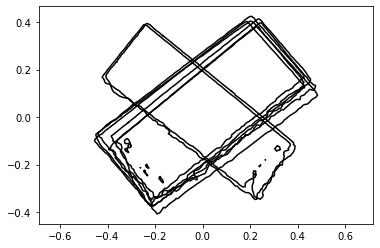

In [140]:
nb.nSobs[0].showIntersections()

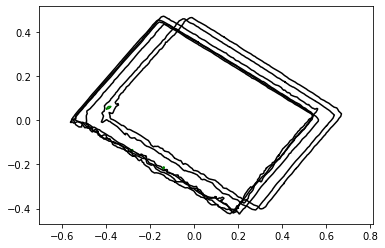

In [141]:
nb.nSobs[1].showIntersections()

In [143]:
nb.nSobs[3].showIntersections()

AttributeError: 'numpy.float64' object has no attribute 'show'

In [9]:
sobs.getAlpha()

In [10]:
sobs.alpha_xyPlane

array([-2.03203436e-08,  2.70391825e-02,  2.47195260e-01,  3.91604858e-02,
        3.18007111e-01,  4.69406281e-02,  3.63090674e-01,  5.12508160e-02,
        3.84158874e-01,  5.23365624e-02,  3.82171843e-01,  5.03324732e-02])

In [11]:
sobs.alpha_xzPlane

array([-2.00425877e-08,  2.79531200e-02,  2.53960095e-01,  4.00741695e-02,
        3.28652815e-01,  4.83773240e-02,  3.77312460e-01,  5.31690261e-02,
        4.01011342e-01,  5.46090632e-02,  4.00366471e-01,  5.27862977e-02])

In [13]:
sob_0 = sobs.nSobs[0]

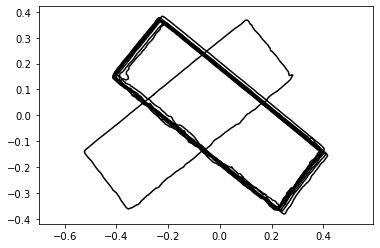

In [14]:
sob_0.showIntersections()

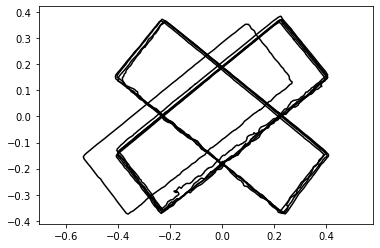

In [15]:
sobs.nSobs[1].showIntersections()

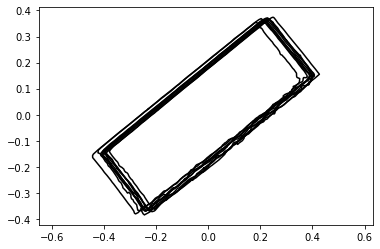

In [16]:
sobs.nSobs[2].showIntersections()

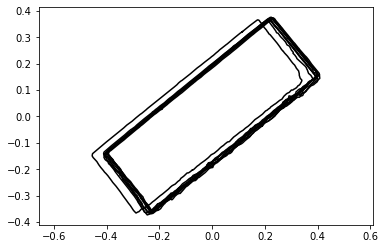

In [17]:
sobs.nSobs[3].showIntersections()

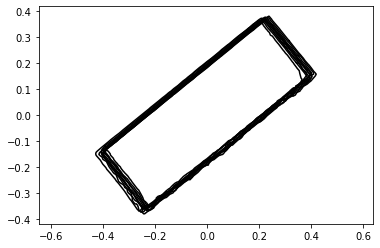

In [18]:
sobs.nSobs[4].showIntersections()

In [21]:
slice = mesh.section(plane_origin=mesh.centroid, 
                 plane_normal=np.array([1, 0, 0]))
slice_2D, to_3D = slice.to_planar()
slice_firstPart = slice_2D.split()[0] # 分割，并选取第一个部分（应该是最大的那个部分）

In [22]:
print(slice)

<trimesh.Path3D(vertices.shape=(358, 3), len(entities)=2)>


In [54]:
slice_firstPart.to_3D(to_3D).centroid

array([-0.91451625, -0.13691134, -5.44386294])

In [4]:
mesh.bounds

array([[-21.28422928,  -1.49518299,  -6.24997091],
       [ 18.52413559,   1.31816697,  -4.69799995]])

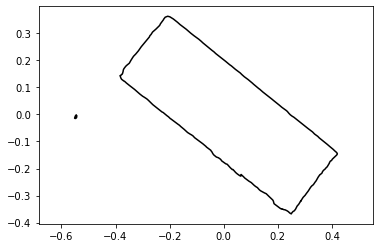

In [4]:
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=[1,0, 0])
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

In [ ]:
slice_

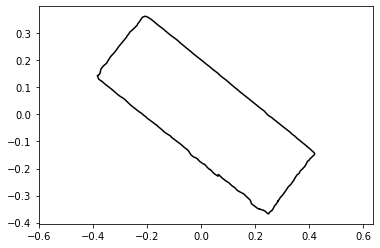

In [14]:
slices_splited = slice_2D.split()
sliceIndex = np.argmax([s.area for s in slices_splited])
slice_2D = slices_splited[sliceIndex]
slice_2D.show()

In [15]:
slice_2D.apply_obb()

array([[ 0.77499324, -0.63196952, -0.01554085],
       [ 0.63196952,  0.77499324, -0.00918349],
       [ 0.        ,  0.        ,  1.        ]])

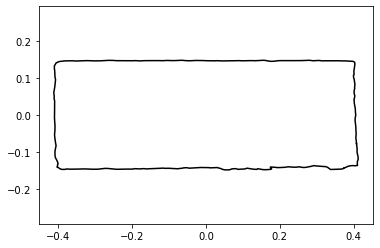

In [16]:
slice_2D.show()

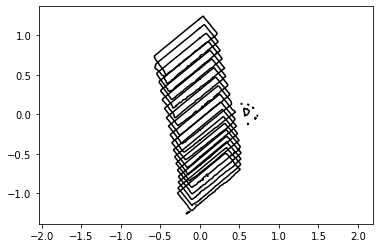

In [20]:
z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=2)
sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                   plane_normal=np.array([1, 0, 0]),
                                   heights=z_levels)

sections = [i for i in sections if i is not None]
combined = np.sum(sections)
combined.show()

In [20]:
import numpy as np


In [36]:
v1 = [1, 0, 0]
v2 = [0, 1, 0]

r = rotation_matrix(v1, v2)
r

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [37]:
np.dot(r, v1)

array([0., 1., 0.])

In [30]:
def projected_point(point, plane_origin, planeVec1, planeVec2):
    """
    已知平面内一原点以及两个正交向量，求已知点在该平面内的投影坐标（二维）
    """
    pVec = np.asarray(point) - np.asarray(plane_origin)
    xVec = np.asarray(planeVec1) / np.linalg.norm(planeVec1)
    yVec = np.asarray(planeVec2) / np.linalg.norm(planeVec2)
    s1 = np.dot(pVec, xVec)
    s2 = np.dot(pVec, yVec)
    
    return np.array([s1, s2])

In [29]:
p = [1, 1, 5]
o = [0, 0, 0]
x = [1, 1, 0]
y = [-1, 1, 0]
projected_point(p, o, x, y)

array([1.41421356, 0.        ])

In [19]:
np.dot(r, v1)

array([0., 1., 0.])

In [14]:
np.arccos(np.dot([0, 1, 0], [1, 0, 0]))

1.5707963267948966

In [15]:
np.pi/2

1.5707963267948966

In [16]:
np.linalg.norm([1, 0, 0])

1.0